In [1]:
import sys
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

sys.path.append("../../../NN_prior/")
from custom_mean import LinearCalibration

In [2]:
data_dir = "data/"
output_dir = "output_files/"
model_dir = "../lcls_cu_injector_nn_model/"

In [3]:
# create base model
base_model = torch.load(model_dir + "model/model.pt")

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_dir + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_dir + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_dir + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_dir + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_dir + "model/pv_variables.yml"))

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_dir + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],  # pv_to_sim before sim_to_nn
    output_transformers=[output_sim_to_nn, output_pv_to_sim],  # sim_to_nn before pv_to_sim
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=lume_model.features,
    output_order=lume_model.outputs[:2],
)

In [4]:
# create LUME-model
cal_lume_model = PyTorchModel(
    model_file="calibrated_model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],  # pv_to_sim before sim_to_nn
    output_transformers=[output_sim_to_nn, output_pv_to_sim],  # sim_to_nn before pv_to_sim
)

In [5]:
# wrap in LUMEModule
cal_lume_module = LUMEModule(
    model=cal_lume_model,
    feature_order=cal_lume_model.features,
    output_order=cal_lume_model.outputs,
)

In [6]:
# define objective models
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)
cal_objective_model = ObjectiveModel(cal_lume_module)

In [7]:
updated_variables = {
    'SOLN:IN20:121:BCTRL': [0.465, 0.48, 0.4779693455075814],
    'QUAD:IN20:121:BCTRL': [-0.015, 0.015, -0.001499227120199691],
    'QUAD:IN20:122:BCTRL': [-0.015, 0.015, -0.0006872989433749197],
    'QUAD:IN20:361:BCTRL': [-3.7, -3.0, -3.0368496452987706],
    'QUAD:IN20:371:BCTRL': [2.448, 2.992, 2.860889851203609],
    'QUAD:IN20:425:BCTRL': [-3.0, 3.0, -0.20217600214382594],
    'QUAD:IN20:441:BCTRL': [-3.0, 3.0, -0.17938799998564897],
    'QUAD:IN20:511:BCTRL': [-3.0, 3.0, 2.852171999771826],
    'QUAD:IN20:525:BCTRL': [-5.0, 5.0, -3.218399988942528]
}

In [8]:
# create reference point
inputs_small = input_pv_to_sim.untransform(torch.load(model_dir + "info/inputs_small.pt"))
ref_x = []
for key in input_variables.keys():
    if key == "QUAD:IN20:425:BACT":
        value = input_variables[key].default
        # value = np.mean(input_variables[key].value_range)
        # value = torch.median(inputs_small[:, list(input_variables.keys()).index(key)]).item()
        # value = torch.mode(inputs_small[:, list(input_variables.keys()).index(key)])
        ref_x.append(value)
    else:
        ref_x.append(input_variables[key].default)
ref_x = torch.FloatTensor(ref_x)
print(objective_model(ref_x.unsqueeze(0)).detach().item())

329.01442177690996


In [9]:
# # create reference point
# ref_x = []
# for key in input_variables.keys():
#     updated_key = key.replace("BACT", "BCTRL")
#     if updated_key in updated_variables.keys():
#         ref_x.append(updated_variables[updated_key][-1])
#     else:
#         ref_x.append(input_variables[key].default)
# ref_x = torch.FloatTensor(ref_x)

In [10]:
# define 1D scan sample function
def scan_ref_x(n_samples, name):
    idx = list(input_variables.keys()).index(name)
    v_lim = input_variables[name].value_range
    samples = ref_x.repeat(n_samples, 1)
    samples[:, idx] = torch.linspace(v_lim[0], v_lim[1], n_samples)
    return samples.double()

In [11]:
# # define 1D scan sample function
# def scan_ref_x(n_samples, name):
#     idx = list(input_variables.keys()).index(name)
#     updated_name = name.replace("BACT", "BCTRL")
#     if updated_name in updated_variables.keys():  #  and not updated_name == 'QUAD:IN20:511:BCTRL'
#         v_lim = updated_variables[updated_name][:2]
#         print(v_lim, input_variables[name].value_range)
#     else:
#         v_lim = input_variables[name].value_range
#     samples = ref_x.repeat(n_samples, 1)
#     samples[:, idx] = torch.linspace(v_lim[0], v_lim[1], n_samples)
#     return samples.double()

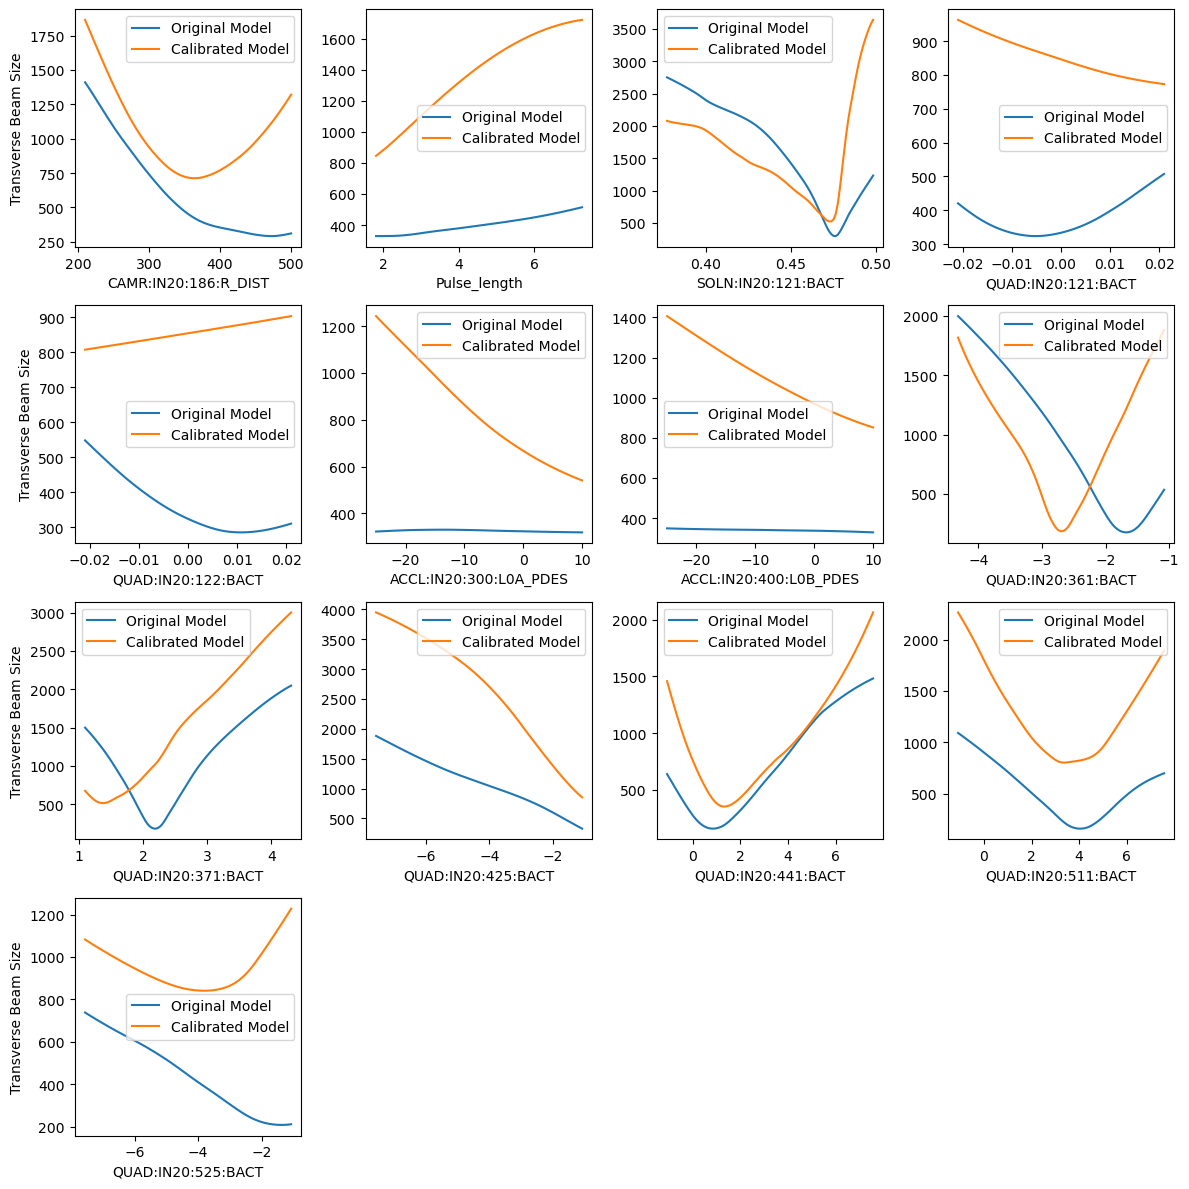

In [12]:
# compare 1D scans for original and calibrated model
n_scan = 100
nrows, ncols = 4, 4
figsize = (12, 12 * nrows / ncols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=False, figsize=figsize)
n_skip = 0
for i in range(nrows * ncols):
    ax_i = ax[i // ncols, i % ncols]
    if i + n_skip >= len(input_variables.keys()):
        ax_i.axis('off')
    else:
        name = list(input_variables.keys())[i + n_skip]
        v_lim = input_variables[name].value_range

        while not v_lim[0] < v_lim[1]:
            n_skip += 1
            name = list(input_variables.keys())[i + n_skip]
            v_lim = input_variables[name].value_range

        # compute 1D scans
        x_scan = scan_ref_x(n_scan, name)
        y_scan = objective_model(x_scan).detach()
        y_scan_cal = cal_objective_model(x_scan).detach()

        # plot data
        idx = list(input_variables.keys()).index(name)
        ax_i.plot(x_scan[:, idx], y_scan, "C0", label="Original Model")
        ax_i.plot(x_scan[:, idx], y_scan_cal, "C1", label="Calibrated Model")
        ax_i.set_xlabel(name)
        ax_i.legend()
        if i % ncols == 0:
            ax_i.set_ylabel("Transverse Beam Size")
fig.tight_layout()